# ImageNet 학습하기

## ImageNet 데이터셋

ILSVRC: ImageNet Large Scale Visual Recognition Competetion [https://deepestdocs.readthedocs.io/en/latest/003_image_processing/0031/]<br>
<p> ImageNet은 ILSVRC 챌린지에서 사용하는 데이터입니다. ImageNet 전 세계에서 모은 이미지들로 챌린지를 열어 누가 컴퓨터 비젼 분야에서 제일 뛰어난 기술을 갖고 있는지를 겨룹니다. 매년 새로운 승자가 등장하고, 그렇게 등장한 기술들은 거의 대부분 반드시 사용해야만 하는 기술이 되곤 합니다. </p>
<p>1,000 종류의 1,281,167 개 데이터가 주어지고 데이터가 어떤 물체인지를 맞추는 챌린지입니다. 각 종류별 데이터의 갯수도 다릅니다. 분류 외에도 탐지(detection) 등 다른 부문도 있지만, 제일 유명한 것은 1,000 종류 분류입니다. 엄청나게 많은 데이터인데다, 전체를 합치면 200GB에 가깝습니다. 이 크기는 절대 GPU에 들어갈 수 없기 때문에 보통 특별한 방법을 써서 GPU 훈련을 시킵니다.</p> 
<p>논문에서 사용하는 ImageNet 데이터는 ILSVRC 2012 의 분류 문제에 사용된 데이터입니다. 실제로 ImageNet 데이터는 저게 전부가 아니고, 훨씬 많은 전 세계에서 모은 데이터들을 모아 놓은 사이트입니다. 다만 이 중 일부를 떼서 챌린지 용으로 사용하는 것 뿐입니다. ImageNet 회원이 되면 비상업적 목적으로 원본 이미지를 다운받을 수도 있고, 이미지의 URL만 받아 불러올 수도 있습니다. 하지만 훈련을 위해서는 역시 원본 이미지가 있어야 합니다. 이미지들의 크기도 전부 다르기 때문에 전처리도 필요합니다.</p>

## Tiny ImageNet
<p>ImageNet은 200GB 넘어 다운받는데만도 하루 이상 걸리기 때문에, 오늘 실습에서는 Tiny ImageNet을 이용할 것입니다. Tiny ImageNet은 스탠포드 CS231N Convolutional Neural Networks for Visual Recognition 수업의 기본 코스 프로젝트에 사용되는 데이터셋입니다. </p>
<p> Tiny Imagenet에는 200 개의 클래스가 있습니다. 각 이미지는 64 X 64로 축소 되었습니다. 각 클래스에는 500 개의 학습 이미지, 50 개의 검증 이미지 및 50 개의 테스트 이미지가 있습니다. </p>

아래의 코드를 터미널 창에 입력하여 데이터셋을 다운받고 압축을 풀 수 있습니다. 
~~~
wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
unzip tiny-imagenet-200.zip
~~~

In [ ]:
!curl http://cs231n.stanford.edu/tiny-imagenet-200.zip --output tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

## Package 로드

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
from tqdm import tqdm

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Add, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers, optimizers

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')

In [3]:
from PIL import Image
from urllib.request import urlopen

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 데이터셋 구조 살펴보기

In [6]:
data_path = 'tiny-imagenet-200'

# os.listdir을 통해 해당 path에 있는 폴더들을 리스트로 받아옵니다. 
os.listdir(os.path.join(data_path, 'train'))

['n03599486',
 'n02364673',
 'n01984695',
 'n04067472',
 'n02002724',
 'n02730930',
 'n02233338',
 'n03026506',
 'n07747607',
 'n03733131',
 'n03201208',
 'n02480495',
 'n02843684',
 'n01629819',
 'n03085013',
 'n09193705',
 'n02206856',
 'n02129165',
 'n02802426',
 'n03902125',
 'n04070727',
 'n02094433',
 'n02236044',
 'n01784675',
 'n01641577',
 'n03126707',
 'n01944390',
 'n03770439',
 'n02231487',
 'n09256479',
 'n07695742',
 'n02917067',
 'n03447447',
 'n01774384',
 'n03649909',
 'n03393912',
 'n09246464',
 'n04118538',
 'n04133789',
 'n02056570',
 'n02823428',
 'n03980874',
 'n03042490',
 'n07579787',
 'n03255030',
 'n03179701',
 'n02423022',
 'n02106662',
 'n03804744',
 'n07720875',
 'n03617480',
 'n03662601',
 'n04371430',
 'n09332890',
 'n02415577',
 'n02909870',
 'n01768244',
 'n04398044',
 'n04456115',
 'n04366367',
 'n04501370',
 'n07871810',
 'n02124075',
 'n07711569',
 'n02988304',
 'n02226429',
 'n04328186',
 'n07734744',
 'n04532106',
 'n03355925',
 'n02793495',
 'n077

In [7]:
tmp_path = os.path.join(data_path, 'train')
img_id = os.listdir(tmp_path)[0]
print ('{0} 폴더의 이미지 갯수: {1}'.format(img_id, len(os.listdir(os.path.join(tmp_path, img_id, 'images')))))
os.listdir(os.path.join(tmp_path, img_id, 'images'))

n03599486 폴더의 이미지 갯수: 500


['n03599486_199.JPEG',
 'n03599486_112.JPEG',
 'n03599486_148.JPEG',
 'n03599486_64.JPEG',
 'n03599486_205.JPEG',
 'n03599486_226.JPEG',
 'n03599486_473.JPEG',
 'n03599486_298.JPEG',
 'n03599486_487.JPEG',
 'n03599486_451.JPEG',
 'n03599486_172.JPEG',
 'n03599486_243.JPEG',
 'n03599486_404.JPEG',
 'n03599486_395.JPEG',
 'n03599486_400.JPEG',
 'n03599486_332.JPEG',
 'n03599486_305.JPEG',
 'n03599486_122.JPEG',
 'n03599486_360.JPEG',
 'n03599486_8.JPEG',
 'n03599486_0.JPEG',
 'n03599486_78.JPEG',
 'n03599486_366.JPEG',
 'n03599486_352.JPEG',
 'n03599486_119.JPEG',
 'n03599486_233.JPEG',
 'n03599486_106.JPEG',
 'n03599486_460.JPEG',
 'n03599486_117.JPEG',
 'n03599486_155.JPEG',
 'n03599486_343.JPEG',
 'n03599486_419.JPEG',
 'n03599486_401.JPEG',
 'n03599486_335.JPEG',
 'n03599486_394.JPEG',
 'n03599486_221.JPEG',
 'n03599486_354.JPEG',
 'n03599486_301.JPEG',
 'n03599486_421.JPEG',
 'n03599486_91.JPEG',
 'n03599486_62.JPEG',
 'n03599486_149.JPEG',
 'n03599486_190.JPEG',
 'n03599486_320.JPE

## 데이터 로드

### Train-set 불러오기

In [8]:
# mini batch size를 16으로 설정합니다.
BATCH_SIZE = 64
# Tiny ImageNet의 class 수 200을 NUM_CLASSES에 저장합니다.
NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
NUM_VAL_IMAGES = 10000

# train-set image가 저장되어있는 장소를 저장합니다.
# validation-set image가 저장되어 있는 장소를 저장합니다.
# test-set image가 저장되어 있는 장소를 저장합니다.
BASE_DIR = './'
TRAINING_IMAGES_DIR = BASE_DIR + 'tiny-imagenet-200/train/'
VAL_IMAGES_DIR = BASE_DIR + 'tiny-imagenet-200/val/'
TEST_IMAGES_DIR = BASE_DIR + 'tiny-imagenet-200/test/'

# Tiny ImageNet의 기본 image size인 64를 저장합니다.
IMAGE_SIZE = 64
NUM_CHANNELS = 3

In [9]:
# Train-set을 읽어와 images에 이미지 데이터, labels에 정답, names에 이미지 파일 이름을 저장합니다.
images = []
labels = []
names = []

for label in tqdm(os.listdir(TRAINING_IMAGES_DIR)):
  #print (label)
  for example in os.listdir(os.path.join(TRAINING_IMAGES_DIR, label, 'images')):
    image_file = os.path.join(TRAINING_IMAGES_DIR, label, 'images', example)
    image_data = Image.open(image_file)
    image_data = image_data.resize((IMAGE_SIZE,IMAGE_SIZE))
    image_data = np.array(image_data)
    
    if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
      images.append(image_data)
      labels.append(label)
      names.append(example)
images = np.asarray(images)
labels = np.asarray(labels)
names = np.asarray(names)

100%|██████████| 200/200 [00:18<00:00, 11.09it/s]


In [10]:
# 저장해놓은 데이터를 헷갈리지 않도록 training이 붙은 변수에 복사합니다.
training_images, training_labels, training_files = images, labels, names

### Validation-set 불러오기

In [11]:
# VAL_IMAGES_DIR 위치에는 images 폴더와 val_annotations.txt 파일이 있습니다.
os.listdir(VAL_IMAGES_DIR)

['images', 'val_annotations.txt']

In [12]:
# train 구조와는 다르게 validation 은 images 파일안에 모든 이미지가 들어있고 
# 정답은 val_annotations.txt에 있습니다.
# val_annoations.txt를 읽어옵니다. 
val_data = pd.read_csv(VAL_IMAGES_DIR + 'val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.head()

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [13]:
name2label = val_data.set_index('File')['Class'].to_dict()

In [14]:
name2label['val_1.JPEG']

'n04067472'

In [15]:
# Validation-set을 읽어와 images에 이미지 데이터, labels에 정답, names에 이미지 파일 이름을 저장합니다.
images = []
labels = []
names = []


for example in tqdm(os.listdir(os.path.join(VAL_IMAGES_DIR, 'images'))):
  # print (example)
  image_file = os.path.join(VAL_IMAGES_DIR, 'images', example)
  image_data = mpimg.imread(image_file)
  label = name2label[example]

  if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
    images.append(image_data)
    labels.append(label)
    names.append(example)
images = np.asarray(images)
labels = np.asarray(labels)
names = np.asarray(names)

100%|██████████| 10000/10000 [00:01<00:00, 5185.13it/s]


In [16]:
# 저장해놓은 데이터를 헷갈리지 않도록 validation 붙은 변수에 복사합니다.
validation_images, validation_labels, validation_files = images, labels, names

### Test-set 불러오기

In [17]:
# TEST_IMAGES_DIR 위치에는 images 폴더만 있습니다.
# test-set에 대한 정답은 공개되어 있지 않으며 아래의 사이트에 정답을 제출하여 성적을 확인할 수 있습니다. 
# https://tiny-imagenet.herokuapp.com/
os.listdir(TEST_IMAGES_DIR)

['images']

In [18]:
# Test-set을 읽어와 images에 이미지 데이터, names에 이미지 파일 이름을 저장합니다.
images = []
names = []


for example in tqdm(os.listdir(os.path.join(TEST_IMAGES_DIR, 'images'))):
  # print (example)
  image_file = os.path.join(TEST_IMAGES_DIR, 'images', example)
  image_data = mpimg.imread(image_file)

  if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
    images.append(image_data)
    names.append(example)
images = np.asarray(images)
names = np.asarray(names)

100%|██████████| 10000/10000 [00:01<00:00, 5373.35it/s]


In [19]:
# 저장해놓은 데이터를 헷갈리지 않도록 testing 붙은 변수에 복사합니다.
testing_images, testing_files = images, names

## 레이블이 무슨 의미일까요?

In [20]:
# words.txt에 레이블이 무슨 의미인지 저장되어 있습니다.
os.listdir(data_path)

['words.txt', 'test', 'wnids.txt', 'train', 'val']

In [21]:
# label에 매칭되는 word를 label2word에 저장합니다.
label2word = pd.read_csv(os.path.join(data_path, 'words.txt'), sep='\t', header=None, names=['label', 'word'])
label2word.head()

,label,word
0,n00001740,entity
1,n00001930,physical entity
2,n00002137,"abstraction, abstract entity"
3,n00002452,thing
4,n00002684,"object, physical object"


In [22]:
# 이용하기 쉽도록 dataframe에서 label을 key로, word를 value로 가진 dictionary로 바꿉니다.
label2word = label2word.set_index('label')['word'].to_dict()

## 이미지 plot 해보기

In [23]:
def plot_object(data):
    plt.figure(figsize=(2,2))
    image = data
    plt.imshow(image.astype(np.uint8), cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    plt.show()

Label: n01984695 / spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish


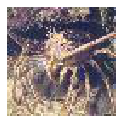

Label: n01984695 / spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish


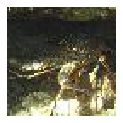

Label: n01984695 / spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish


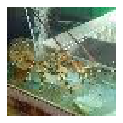

Label: n01984695 / spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish


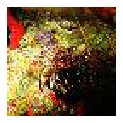

Label: n01984695 / spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish


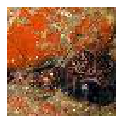

In [24]:
for label, example in list(zip(training_labels, training_images))[1000:1005]:
  print ('Label: {0} / {1}'.format(label, label2word[label]))
  plot_object(example)

## ResNet 구조 살펴보기

In [25]:
resnet = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 55s 1us/step


40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02112018', 'Pomeranian', 0.70623475), ('n02113023', 'Pembroke', 0.058862913), ('n02105855', 'Shetland_sheepdog', 0.034942053)]


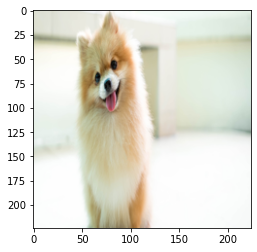

In [26]:
url = 'https://d17fnq9dkz9hgj.cloudfront.net/uploads/2018/04/Pomeranian_02.jpg' # 귀여운 강아지 이미지
img = Image.open(urlopen(url))
img = img.resize((224, 224))
imshow(np.asarray(img))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)

print('Predicted:', decode_predictions(preds, top=3)[0])

In [27]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config) as sess:
    resnet.summary()

[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]   

## Tiny ImageNet에 맞게 Transfer learning 하기

In [28]:
# 몇 epoch을 학습할지 EPOCH에 저장합니다.
EPOCHS = 10

In [29]:
# fully connected layer를 제외한 resnet50 imagenet pretrained model을 생성하여 resnet_conv에 저장합니다.
# pretrained된 모델은 imagenet의 200 GB가 넘는 train-set에 대해 학습되어져 있습니다.
resnet_conv = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

94773248/94765736 [==============================] - 51s 1us/step


In [30]:
# resnet_conv의 모든 layer를 학습되지 않도록 설정합니다.
for layer in resnet_conv.layers:
  layer.trainable = False

In [31]:
# model을 새로 생성합니다.
model = Sequential()
# model에 resnet_conv를 추가합니다.
model.add(resnet_conv)
# resnet_conv의 마지막 convolution을 한 줄로 펼칩니다.
model.add(Flatten())
# 1024개의 node를 output으로 가지는 fully connected layer를 만듭니다.
# activation function은 relu로 설정합니다.
model.add(Dense(1024, activation='relu'))
# NUM_CLASSES만큼의 노드를 만들고 softmax를 연결하여 확률이 출력되도록 합니다.
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [32]:
# cost function은 multi class classification에 일반적으로 사용하는 categorical crossentropy를 설정합니다.
# optimizer는 Momemtum을 사용하고 learning rate은 0.001, momumtum 값은 0.9로 설정합니다.
model.compile(
  loss='categorical_crossentropy',
#  optimizer=optimizers.SGD(lr=0.001, momentum=0.9),
   optimizer=optimizers.Adam(lr=0.001),
   metrics=['accuracy'])

In [33]:
# train-set image는 resnet50용 preproces_input을 사용하여 preprocess를 합니다.
# 각종 data augmentation 기법을 사용하여 무작위로 확대 축소 회전 반전 등을 해줍니다.
train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            horizontal_flip=True,
            fill_mode='nearest',
            zoom_range=0.3,
            width_shift_range=0.3,
            height_shift_range=0.3,
            rotation_range=30)

In [34]:
# TRAINING_IMAGES_DIR에 저장되어 있는 image data들을 train-set data로 사용합니다.
# image data들은 IMAGE_SIZE * IMAGE_SIZE로 변환하여 사용합니다.
# mini batch size는 BATCH_SIZE로 설정합니다.
train_generator = train_datagen.flow_from_directory(
          TRAINING_IMAGES_DIR,
          target_size=(IMAGE_SIZE, IMAGE_SIZE),
          class_mode="categorical",
          batch_size=BATCH_SIZE)
label2id = (train_generator.class_indices)

Found 100000 images belonging to 200 classes.


In [35]:
# validation-set image는 resnet50용 preproces_input을 사용하여 preprocess를 합니다.
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [36]:
val_data.head()

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [37]:
# val_data를 이용하여 validation dataset을 구성합니다. 
validation_generator = val_datagen.flow_from_dataframe(
          dataframe=val_data,
          directory=os.path.join(VAL_IMAGES_DIR, 'images'),
          x_col="File",
          y_col="Class",
          target_size=(IMAGE_SIZE, IMAGE_SIZE),
          class_mode="categorical",
          batch_size=BATCH_SIZE)

Found 10000 validated image filenames belonging to 200 classes.


In [38]:
# SETP_SIZE는 한 epoch 당 몇개의 mini batch를 이용할 지 결정합니다. 
# 원래 STEP_SIZE_TRAIN으로 하면 한 epoch당 약 30분 정도 학습 시간이 소요됩니다.
STEP_SIZE_TRAIN = 5 # 5 # train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = 1 # 1 # validation_generator.n//validation_generator.batch_size

In [39]:
# train-set을 이용하여 모델을 학습하고 validation-set을 이용하여 모델을 평가합니다. 
history = model.fit_generator(
      train_generator,
      epochs=EPOCHS,
      steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=validation_generator,
      validation_steps=STEP_SIZE_VALID,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 1 steps
Epoch 1/10
5/5 [==============================] - 4s 732ms/step - loss: 7.5803 - accuracy: 0.0219 - val_loss: 11.0479 - val_accuracy: 0.0312
Epoch 2/10
5/5 [==============================] - 1s 128ms/step - loss: 6.4113 - accuracy: 0.0312 - val_loss: 8.2935 - val_accuracy: 0.0625
Epoch 3/10
5/5 [==============================] - 1s 136ms/step - loss: 5.6228 - accuracy: 0.0437 - val_loss: 6.9777 - val_accuracy: 0.0312
Epoch 4/10
5/5 [==============================] - 1s 136ms/step - loss: 5.3532 - accuracy: 0.0562 - val_loss: 6.0359 - val_accuracy: 0.0312
Epoch 5/10
5/5 [==============================] - 1s 135ms/step - loss: 5.0167 - accuracy: 0.0625 - val_loss: 5.6264 - val_accuracy: 0.0625
Epoch 6/10
5/5 [==============================] - 1s 205ms/step - loss: 5.0075 - accuracy: 0.0486 - val_loss: 5.6543 - val_accuracy: 

In [40]:
# evaluate_generator를 이용하여 모델의 성능을 평가할 수 도 있습니다. 
model.evaluate_generator(generator=validation_generator, steps=STEP_SIZE_VALID)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


[6.125791549682617, 0.09375]

In [41]:
def plot_loss(history):
    plt.plot(history.history['loss'],'-o')
    plt.plot(history.history['val_loss'],'-o')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)
    
def plot_acc(history):
    plt.plot(history.history['accuracy'],'-o')
    plt.plot(history.history['val_accuracy'],'-o')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)


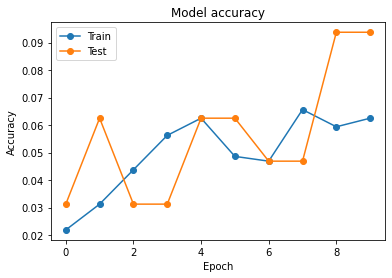

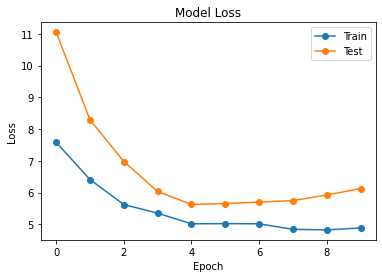

In [42]:
# 학습하는 동안 모델의 정확도와 손실도가 어떻게 변화하였는지 그래프로 확입합니다. 
plot_acc(history)
plt.show()

plot_loss(history)
plt.show()

## Test-set에 모델 평가하기

In [43]:
# test-set을 읽어와 images에 이미지 데이터, labels에 정답, names에 이미지 파일 이름을 저장합니다.
images = []
names = []


for example in tqdm(os.listdir(os.path.join(TEST_IMAGES_DIR, 'images'))):
  # print (example)
  image_file = os.path.join(TEST_IMAGES_DIR, 'images', example)
  image_data = mpimg.imread(image_file)

  if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
    images.append(image_data)
    names.append(example)
images = np.asarray(images)
names = np.asarray(names)

100%|██████████| 10000/10000 [00:01<00:00, 5267.80it/s]


In [44]:
# 저장해놓은 데이터를 헷갈리지 않도록 test 붙은 변수에 복사합니다.
test_images, test_files = images, names

In [45]:
# test-set image는 resnet50용 preproces_input을 사용하여 preprocess를 합니다.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [46]:
# test-set에는 정답없이 이미지만 존재하기 때문에 데이터셋을 읽어오기 쉽도록 dataframe을 만듭니다. 
# File 컬럼에는 이미지 파일 이름이 들어가 있고, Class에는 가짜 label이 들어있습니다. 
test_data = pd.DataFrame(index=range(len(test_images)), columns=['File', 'Class'])

test_data['File'] = test_files
test_data['Class'] = 'n01443537' # Trash value

In [47]:
# 예측하기 쉽도록 test_data를 파일 이름 순으로 정렬합니다. 
test_data = test_data.sort_values(by=['File'])
test_data = test_data.reset_index(drop=True)

In [48]:
# test_data를 이용하여 test-set을 읽어옵니다. 
test_generator = test_datagen.flow_from_dataframe(
          dataframe=test_data,
          directory=os.path.join(TEST_IMAGES_DIR, 'images'),
          x_col="File",
          y_col="Class",
          target_size=(IMAGE_SIZE, IMAGE_SIZE),
          class_mode=None,
          batch_size=16)

Found 9811 validated image filenames.


In [49]:
# STEP_SIZE는 한 epoch 당 몇 개의 mini batch를 이용할지 결정합니다. 
STEP_SIZE_TEST = 1 # test_generator.n//test_generator.batch_size

In [50]:
# test-set에 대하여 예측합니다. 
# preds = model.predict_generator(test_generator, steps = STEP_SIZE_TEST)
preds = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [51]:
# 모델에서 예측값은 200개의 클래스에 대한 확률로 나타나므로, 가장 확률이 높은 label의 index를 저장합니다. 
predicted_class_indices = np.argmax(preds, axis=1)

In [52]:
predicted_class_indices

array([162, 117, 147, ..., 174, 162,  84])

In [53]:
# index에 해당하는 label을 predictions에 저장합니다. 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [54]:
# predictions를 이용하여 Class에 예측 label (class)를 저장합니다. 
test_data.loc[:len(predictions)-1, 'Class'] = predictions

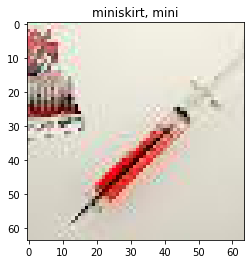

In [55]:
# 그림과 그림에 해당하는 예측값을 나타냅니다. 
cnt = 0
for name, label in zip(test_data['File'].values, test_data['Class'].values):
    image_data = Image.open(os.path.join(TEST_IMAGES_DIR, 'images', name))
    imshow(np.asarray(image_data))
    plt.title(label2word[label])
    if cnt >= 3:
        break
    cnt += 1